<a href="https://colab.research.google.com/github/tasdir/DeepLearning/blob/main/Attention_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset preparation
def prepare_data(batch_size=1024):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [22]:
class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(5, 3, kernel_size=3, padding=1)

        # Projection layers for attention mechanisms
        self.project_g_to_l1 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=1)
        self.project_g_to_l2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1)


        # Fully connected layers
        self.fc1 = nn.Linear(7 * 7 * 3, 147)
        self.fc2 = nn.Linear(147, 10)

    def attention_mechanism(self, l, g, projection_layer):
        # Project g to match l's dimensions
        g_projected = projection_layer(g)  # Ensure dimensions match

        # # Debugging: Print shapes of tensors
        # print(f"l shape: {l.shape}, g shape: {g.shape}, g_projected shape: {g_projected.shape}")

        # Compatibility scores (dot product)
        compatibility_scores = torch.einsum('bchw,bchw->bhw', l, g_projected)

        # Normalize scores to derive attention weights
        attention_weights = F.softmax(compatibility_scores.view(compatibility_scores.size(0), -1), dim=-1).view_as(compatibility_scores)

        # Apply attention weights to local features
        attention_output = attention_weights.unsqueeze(1) * l

        return attention_output, attention_weights



    def forward(self, x):
        # Initial convolutions
        x = F.relu(self.conv1(x))  # Output: 28x28x3
        x = F.relu(self.conv2(x))  # Output: 28x28x5

        # # Debugging: Print shape after initial convolutions
        # print(f"After Conv2: {x.shape}")

        # Attention 1 applied to 28x28x5
        attention_output1, attention_weights1 = self.attention_mechanism(x, x, self.project_g_to_l1)

        # First max pooling
        f1 = F.max_pool2d(attention_output1, kernel_size=2)  # Output: 14x14x5

        # # Debugging: Print shape after Attention 1 and pooling
        # print(f"After Attention 1 and Pooling: {f1.shape}")

        # Further convolutions
        x = F.relu(self.conv3(f1))  # Output: 14x14x5
        x = F.relu(self.conv4(x))   # Output: 14x14x3

        # # Debugging: Print shape after further convolutions
        # print(f"After Conv4: {x.shape}")

        # Attention 2 applied to 14x14x3
        attention_output2, attention_weights2 = self.attention_mechanism(x, x, self.project_g_to_l2)

        # # Debugging: Print shape after Attention 2
        # print(f"After Attention 2: {attention_output2.shape}")

        # Second max pooling
        f2 = F.max_pool2d(attention_output2, kernel_size=2)  # Output: 7x7x3

        # # Debugging: Print shape after second pooling
        # print(f"After Second Pooling: {f2.shape}")

        # Flatten and fully connected layers
        g = f2.view(f2.size(0), -1)  # Flatten to (batch_size, 147)
        x = F.relu(self.fc1(g))
        x = self.fc2(x)

        return x, attention_weights1, attention_weights2




In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, device='cpu'):
    model.train()
    train_loss_list, val_loss_list = [], []

    for epoch in range(epochs):
        total_loss, val_loss = 0, 0

        # Training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss_list.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _, _ = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss_list.append(val_loss / len(val_loader))
        model.train()

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss_list[-1]}, Val Loss: {val_loss_list[-1]}")

    return train_loss_list, val_loss_list


In [11]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred))


In [12]:
def visualize_attention_maps(model, test_loader, device='cpu'):
    model.eval()
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, att1, att2 = model(images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            for i in range(10):  # Visualize 10 samples
                image = images[i].cpu().numpy().squeeze()
                att1_map = att1[i].cpu().numpy().squeeze()
                att2_map = att2[i].cpu().numpy().squeeze()

                # Normalize attention maps
                att1_map = (att1_map - att1_map.min()) / (att1_map.max() - att1_map.min())
                att2_map = torch.tensor(att2_map).unsqueeze(0).unsqueeze(0)
                att2_map = F.interpolate(att2_map, size=(28, 28), mode='bilinear').squeeze().numpy()
                att2_map = (att2_map - att2_map.min()) / (att2_map.max() - att2_map.min())

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(image, cmap='gray')

                plt.subplot(1, 3, 2)
                plt.title("Attention 1 Heatmap")
                plt.imshow(image, cmap='gray')
                plt.imshow(att1_map, cmap='jet', alpha=0.5)

                plt.subplot(1, 3, 3)
                plt.title("Attention 2 Heatmap")
                plt.imshow(image, cmap='gray')
                plt.imshow(att2_map, cmap='jet', alpha=0.5)

                plt.suptitle(f"True: {class_names[labels[i].item()]}, Pred: {class_names[preds[i].item()]}, Prob: {probs[i].max():.2f}")
                plt.show()
            break


Epoch 1, Train Loss: 2.30300284446554, Val Loss: 2.302757998307546
Epoch 2, Train Loss: 2.3027046031140266, Val Loss: 2.302715619405111
Epoch 3, Train Loss: 2.3027403912645705, Val Loss: 2.302730083465576
Epoch 4, Train Loss: 2.286264434773871, Val Loss: 2.002481440703074
Epoch 5, Train Loss: 1.4965408051267584, Val Loss: 1.3854560554027557
Epoch 6, Train Loss: 1.3398449065837454, Val Loss: 1.3393867711226146
Epoch 7, Train Loss: 1.312463752766873, Val Loss: 1.3149928351243336
Epoch 8, Train Loss: 1.2892092187353905, Val Loss: 1.2993471125761669
Epoch 9, Train Loss: 1.2805634787742128, Val Loss: 1.2928786774476368
Epoch 10, Train Loss: 1.2662391129960404, Val Loss: 1.2820014854272206


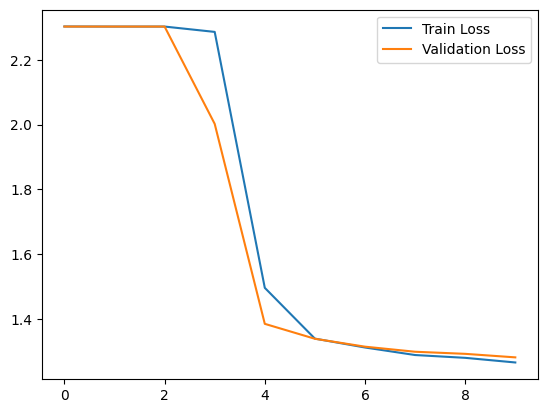

Confusion Matrix:


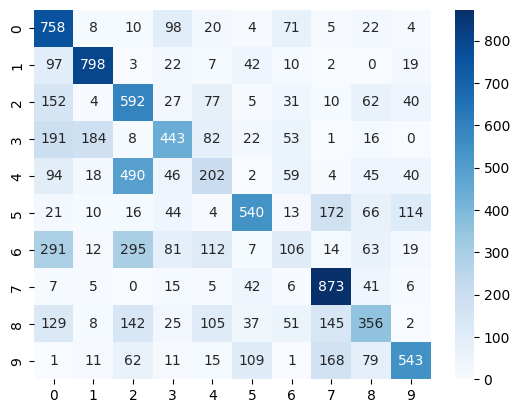

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.76      0.55      1000
           1       0.75      0.80      0.78      1000
           2       0.37      0.59      0.45      1000
           3       0.55      0.44      0.49      1000
           4       0.32      0.20      0.25      1000
           5       0.67      0.54      0.60      1000
           6       0.26      0.11      0.15      1000
           7       0.63      0.87      0.73      1000
           8       0.47      0.36      0.41      1000
           9       0.69      0.54      0.61      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.50     10000
weighted avg       0.51      0.52      0.50     10000



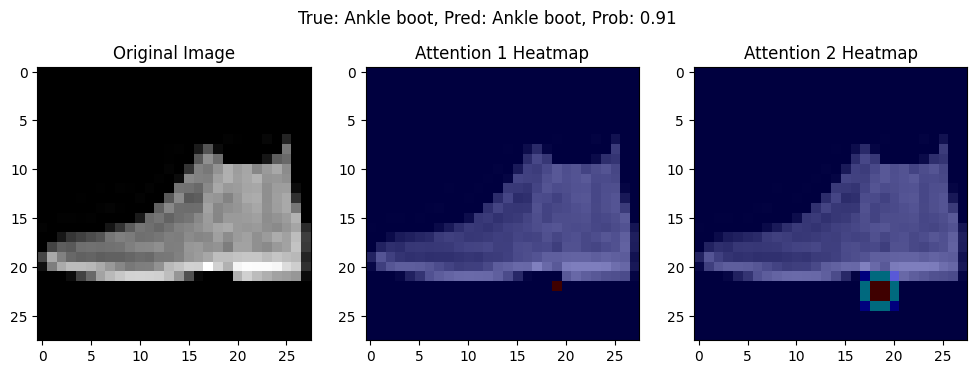

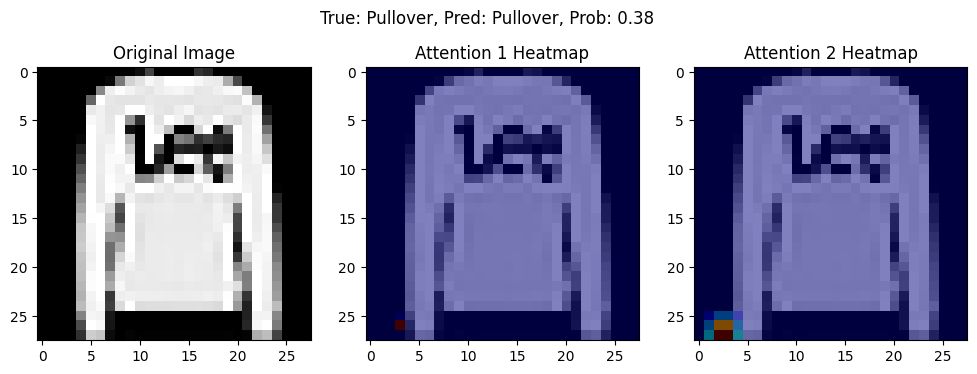

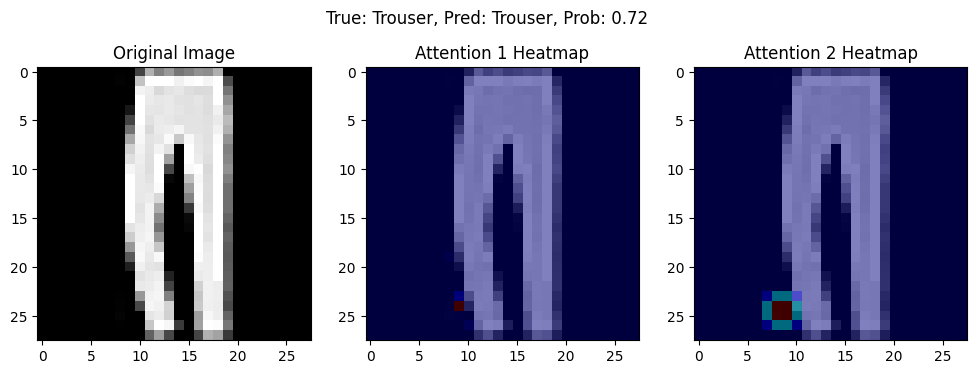

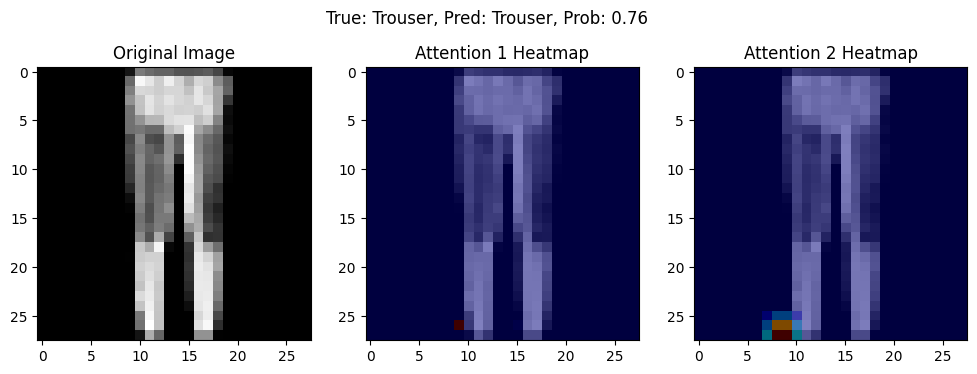

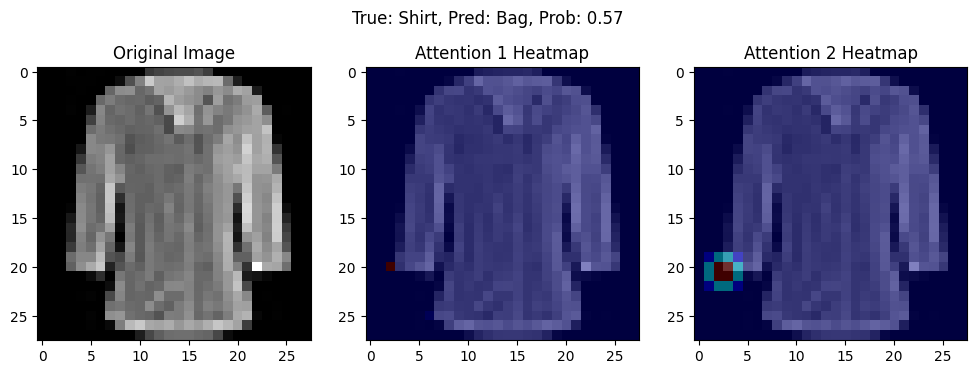

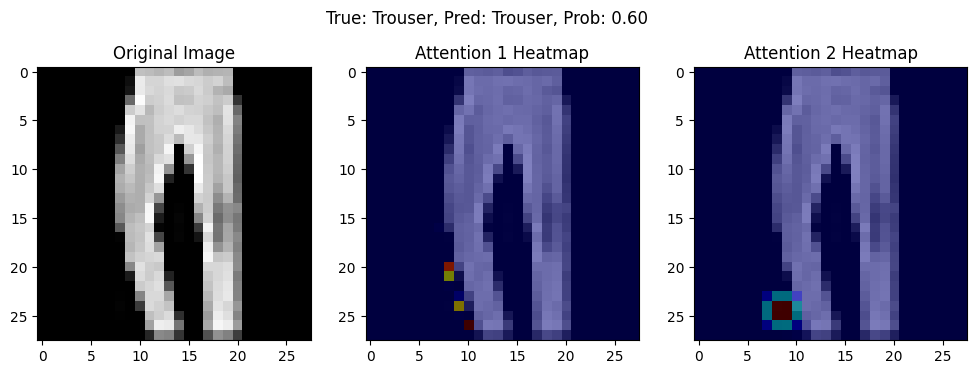

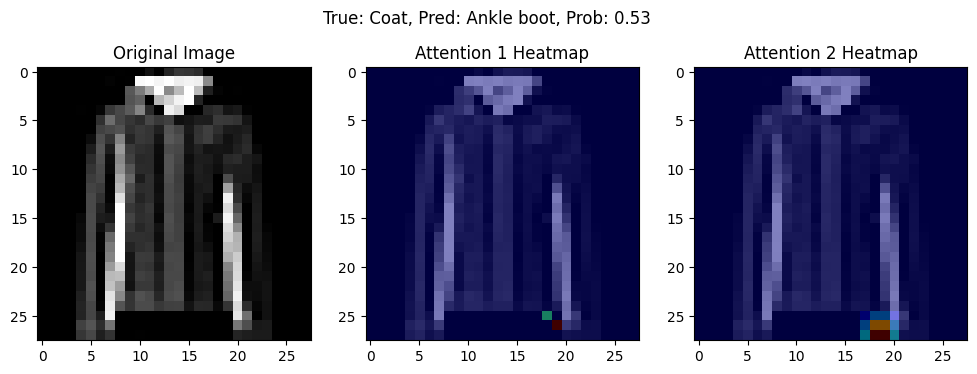

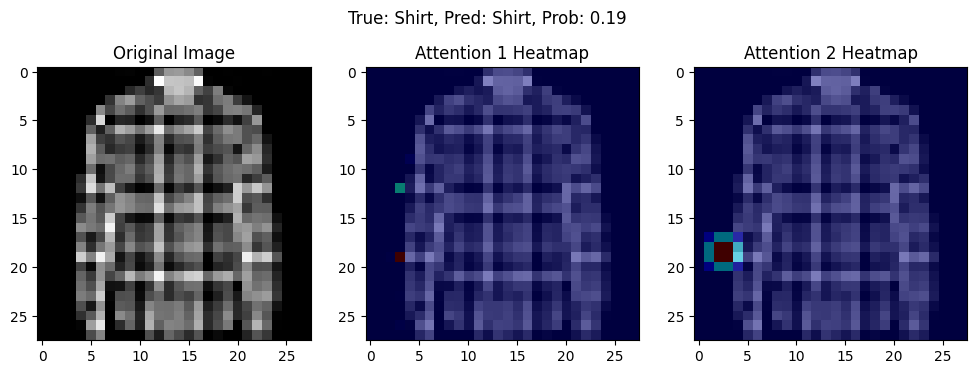

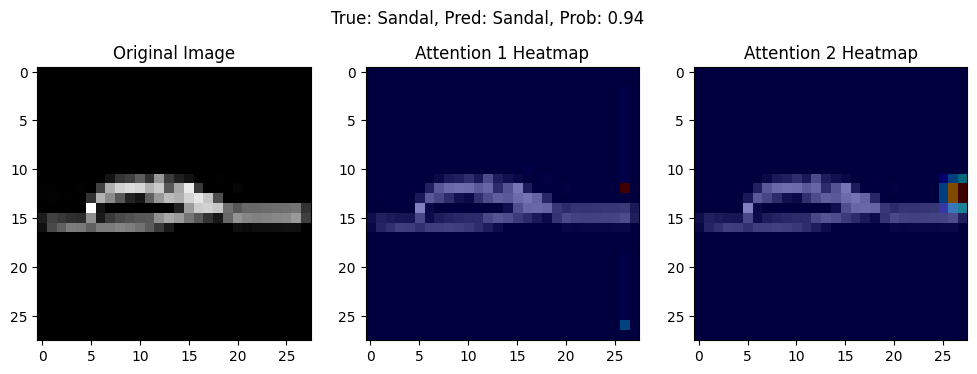

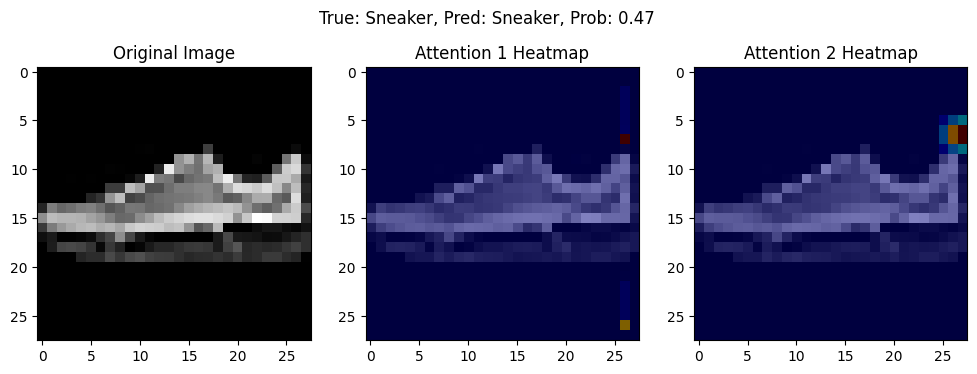

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
train_loader, val_loader, test_loader = prepare_data(batch_size=1024)

# Initialize model, optimizer, and loss function
model = AttentionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, device=device)

# Plot losses
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

# Evaluate the model
evaluate_model(model, test_loader, device=device)

# Visualize attention maps
visualize_attention_maps(model, test_loader, device=device)


In [24]:
import random

def get_incorrect_samples(model, test_loader, num_samples=30, device='cpu'):
    """
    Collect incorrect predictions from the test set.
    """
    model.eval()
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, att1, att2 = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:  # Only consider incorrect predictions
                    incorrect_samples.append({
                        "image": images[i].cpu(),
                        "label": labels[i].item(),
                        "pred": preds[i].item(),
                        "probs": probs[i].cpu(),
                        "att1": att1[i].cpu(),
                        "att2": att2[i].cpu()
                    })

            # Stop once we have enough incorrect samples
            if len(incorrect_samples) >= num_samples:
                break

    # Randomly select the required number of incorrect samples
    random.shuffle(incorrect_samples)
    return incorrect_samples[:num_samples]


In [25]:
def visualize_incorrect_predictions(incorrect_samples, class_names):
    """
    Visualize input images and attention maps for incorrect predictions.
    """
    for sample in incorrect_samples:
        image = sample["image"].numpy().squeeze()
        att1_map = sample["att1"].numpy().squeeze()
        att2_map = sample["att2"].numpy().squeeze()
        label = sample["label"]
        pred = sample["pred"]
        probs = sample["probs"]

        # Normalize attention maps
        att1_map = (att1_map - att1_map.min()) / (att1_map.max() - att1_map.min())
        att2_map = torch.tensor(att2_map).unsqueeze(0).unsqueeze(0)
        att2_map = F.interpolate(att2_map, size=(28, 28), mode='bilinear').squeeze().numpy()
        att2_map = (att2_map - att2_map.min()) / (att2_map.max() - att2_map.min())

        # Get probability scores for ground truth and predicted classes
        true_prob = probs[label].item()
        pred_prob = probs[pred].item()

        # Plot the images and attention maps
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.title("Original Image")
        plt.imshow(image, cmap='gray')

        plt.subplot(1, 4, 2)
        plt.title("Attention 1 (Predicted Class)")
        plt.imshow(image, cmap='gray')
        plt.imshow(att1_map, cmap='jet', alpha=0.5)

        plt.subplot(1, 4, 3)
        plt.title("Attention 2 (Predicted Class)")
        plt.imshow(image, cmap='gray')
        plt.imshow(att2_map, cmap='jet', alpha=0.5)

        plt.subplot(1, 4, 4)
        plt.axis("off")
        plt.text(0, 0.5, f"True: {class_names[label]}\n"
                         f"Pred: {class_names[pred]}\n"
                         f"True Prob: {true_prob:.2f}\n"
                         f"Pred Prob: {pred_prob:.2f}",
                 fontsize=12, ha="left", va="center")

        plt.tight_layout()
        plt.show()


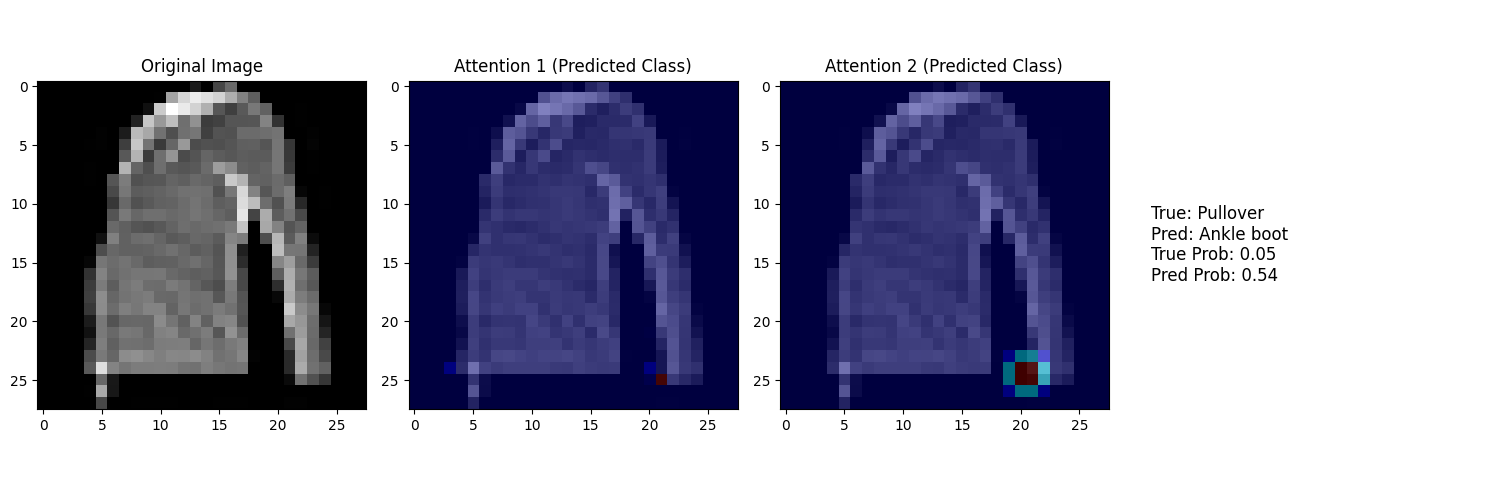

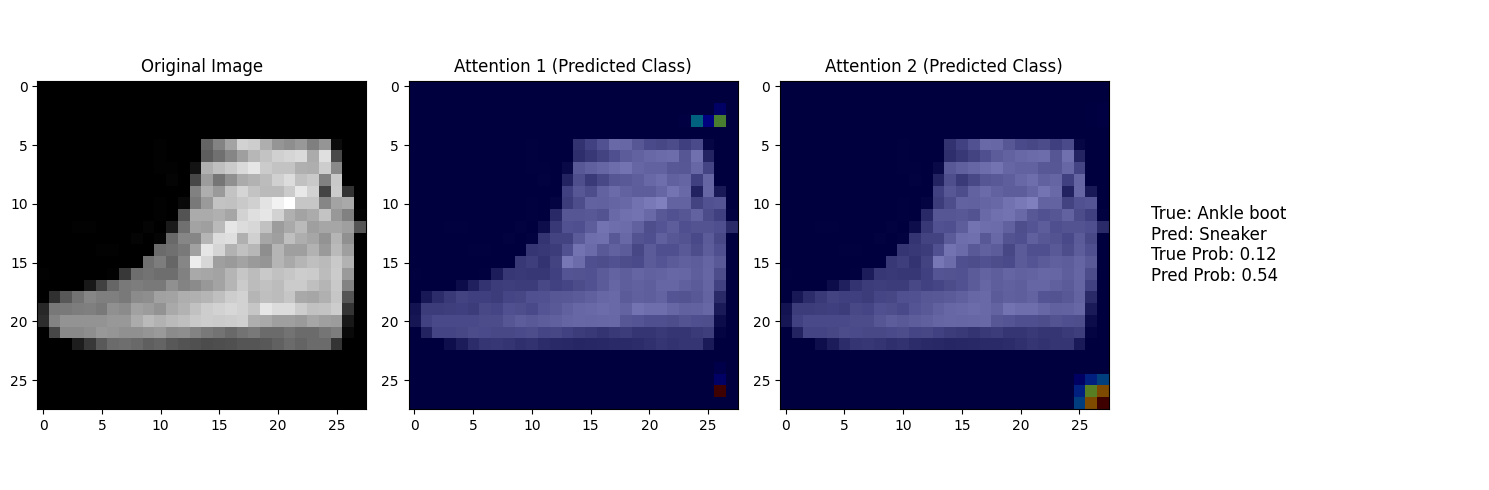

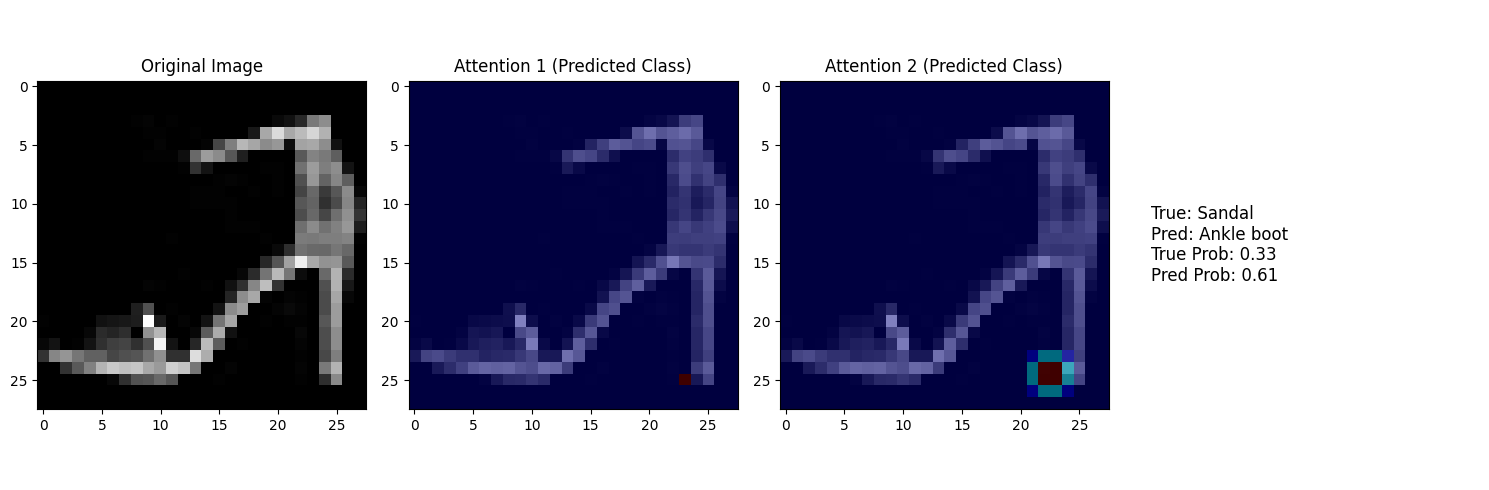

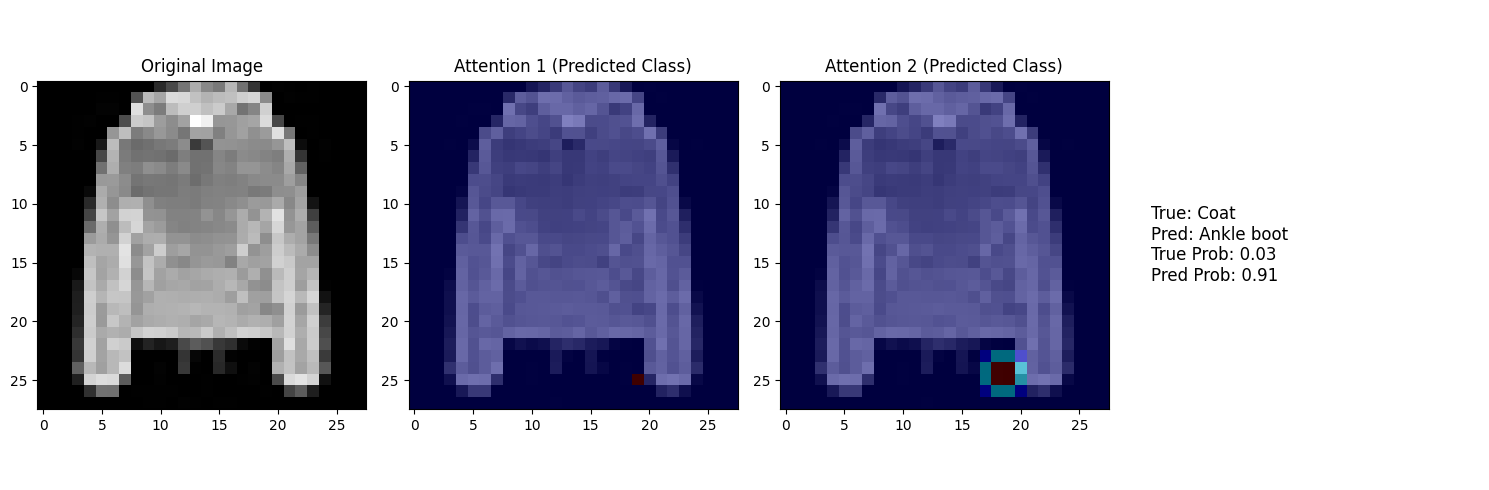

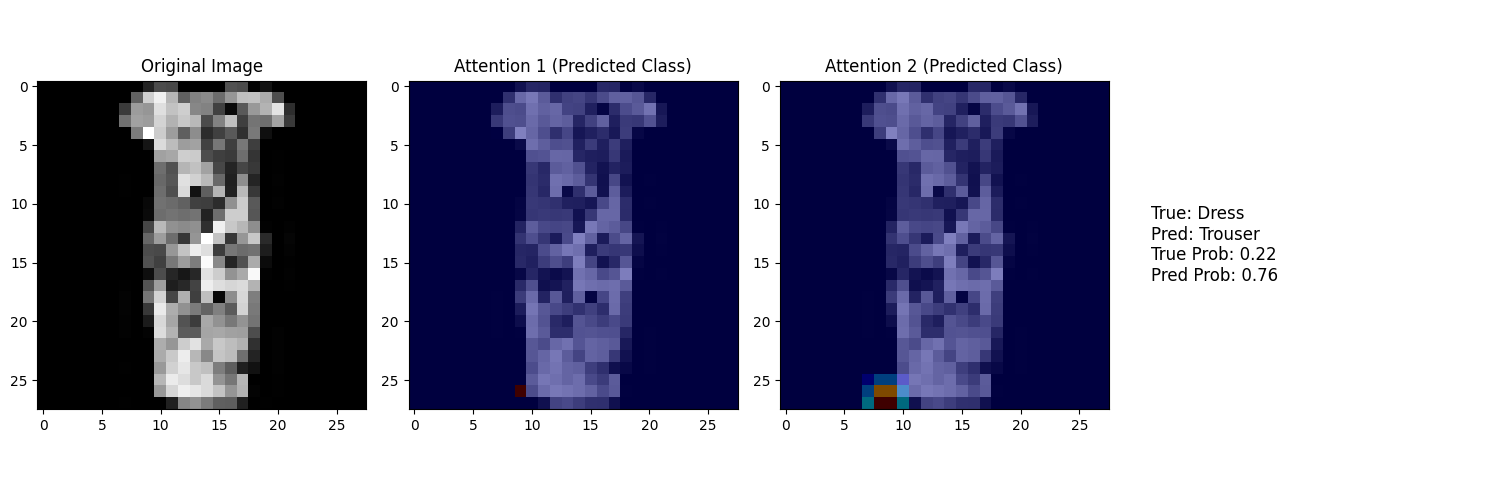

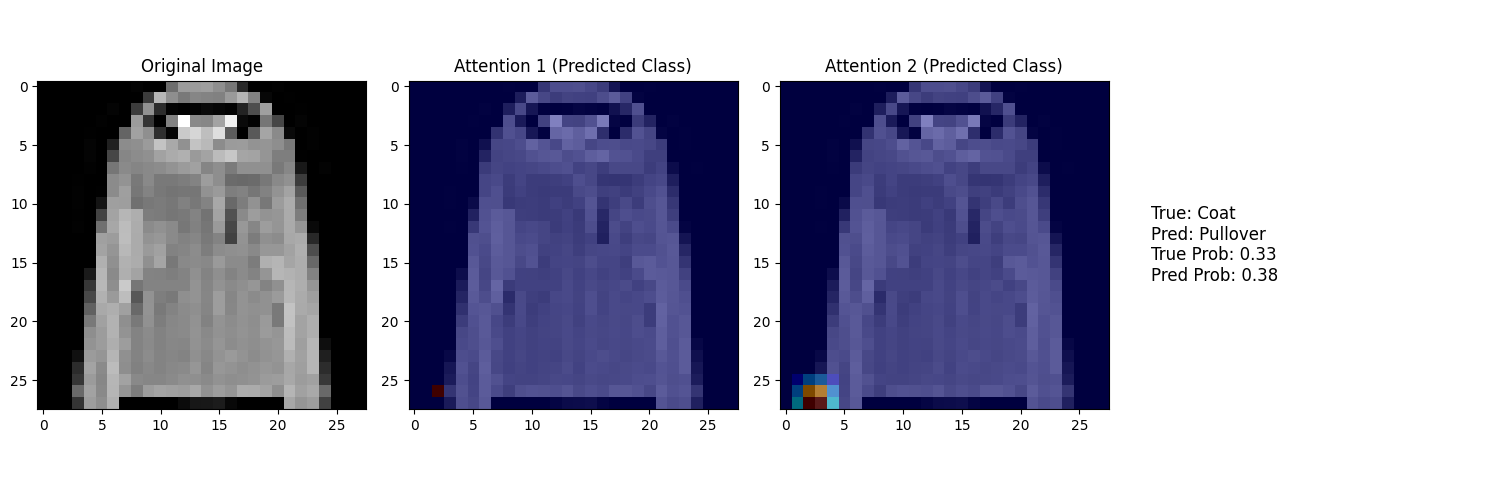

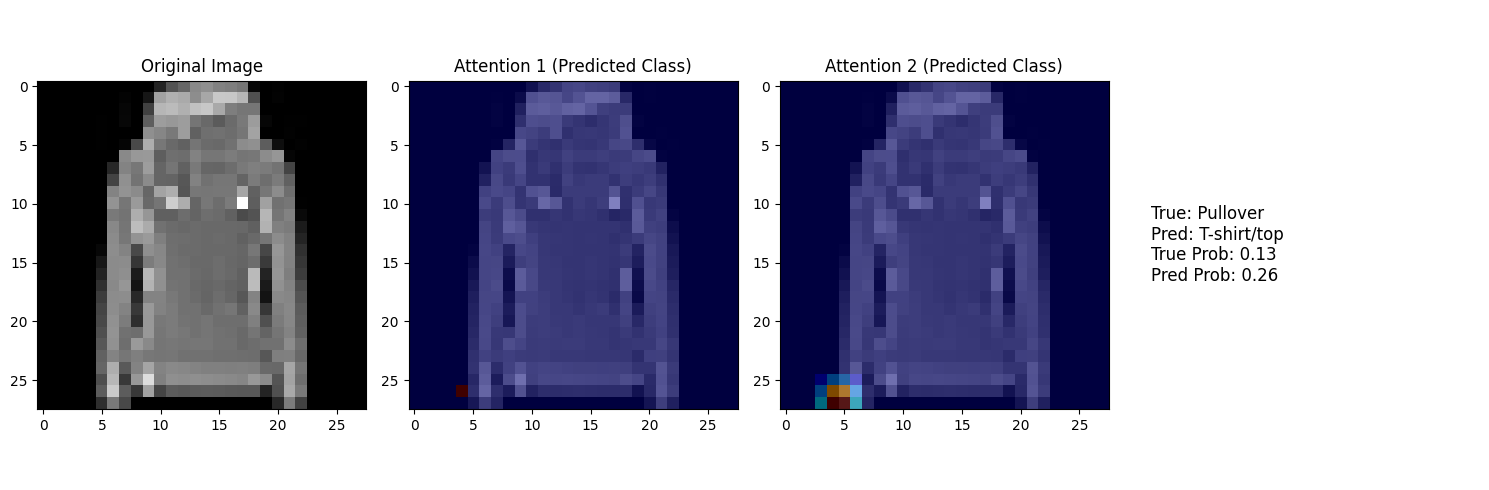

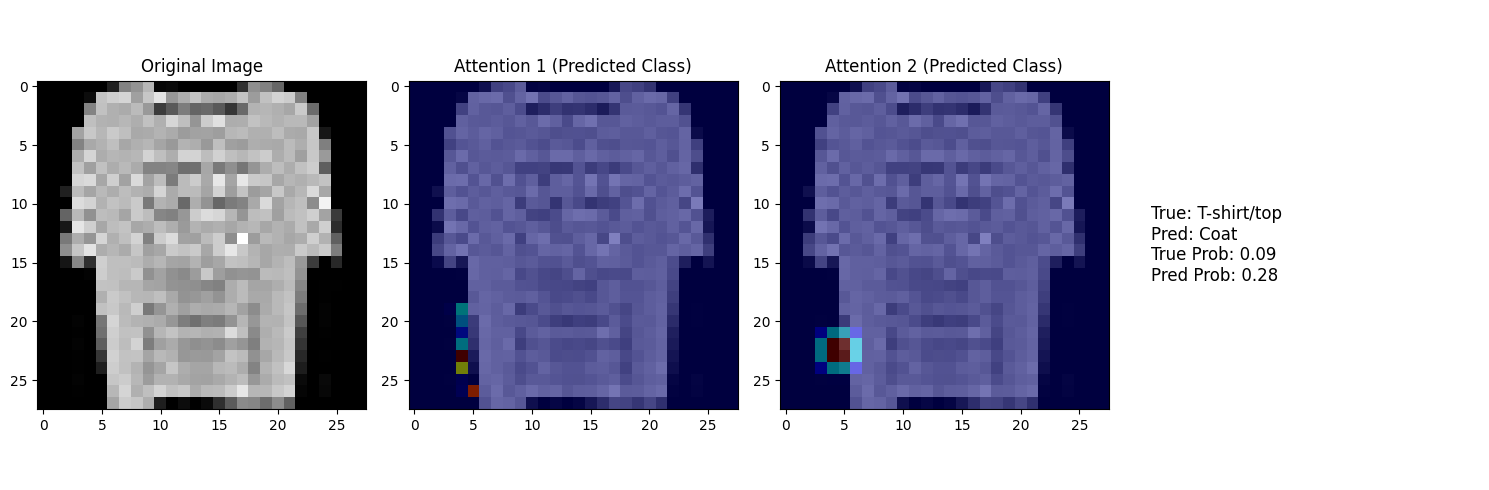

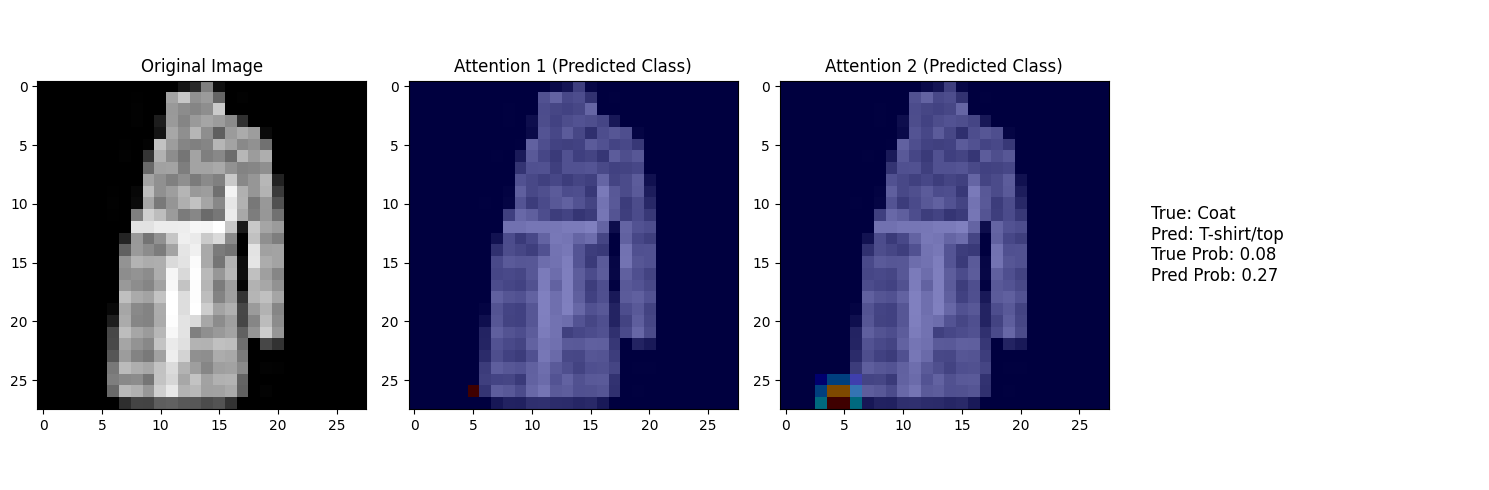

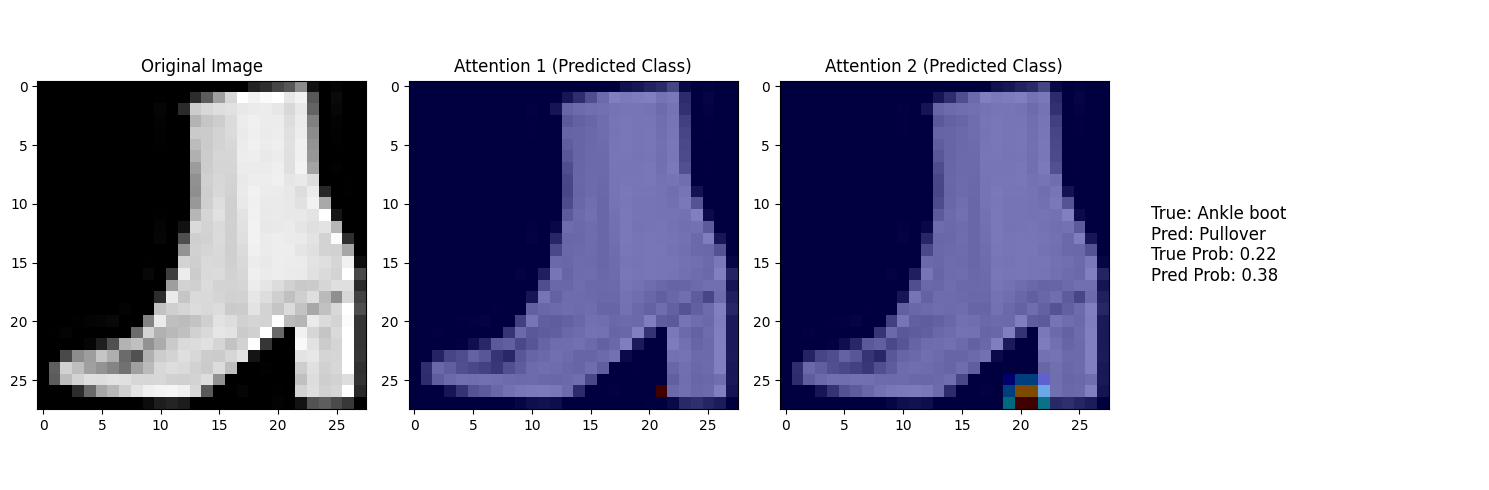

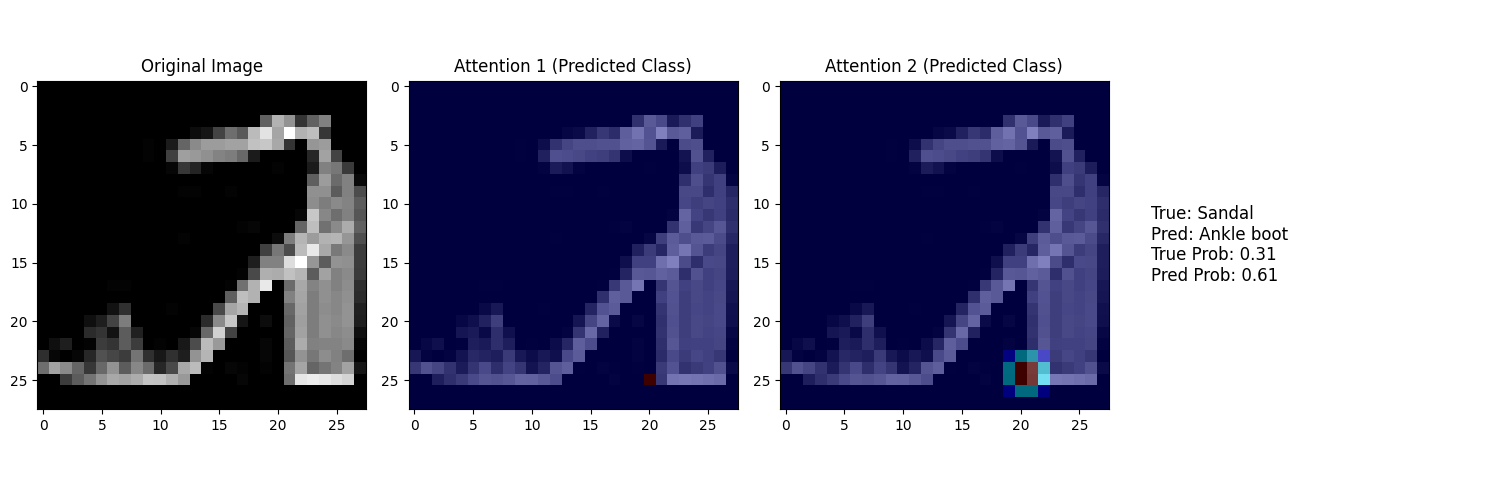

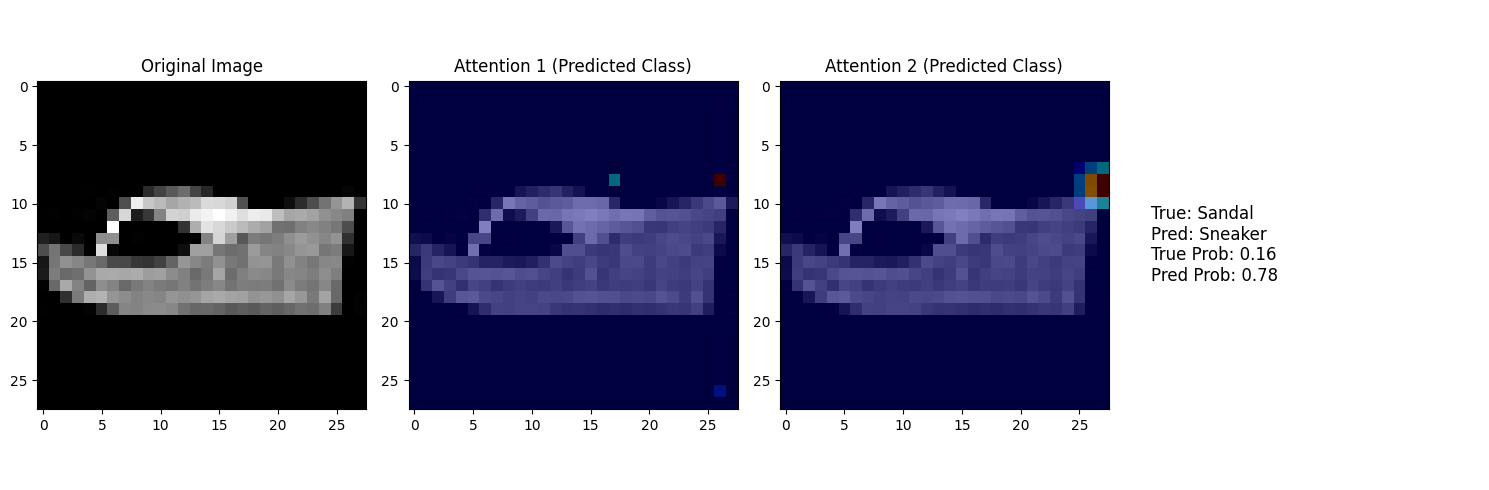

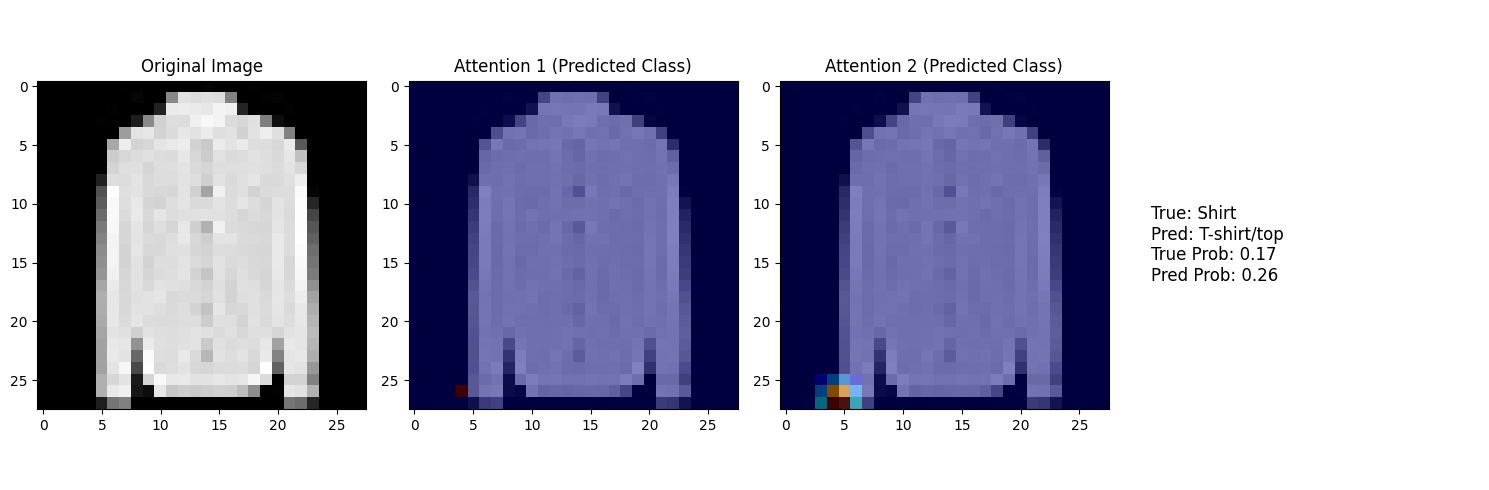

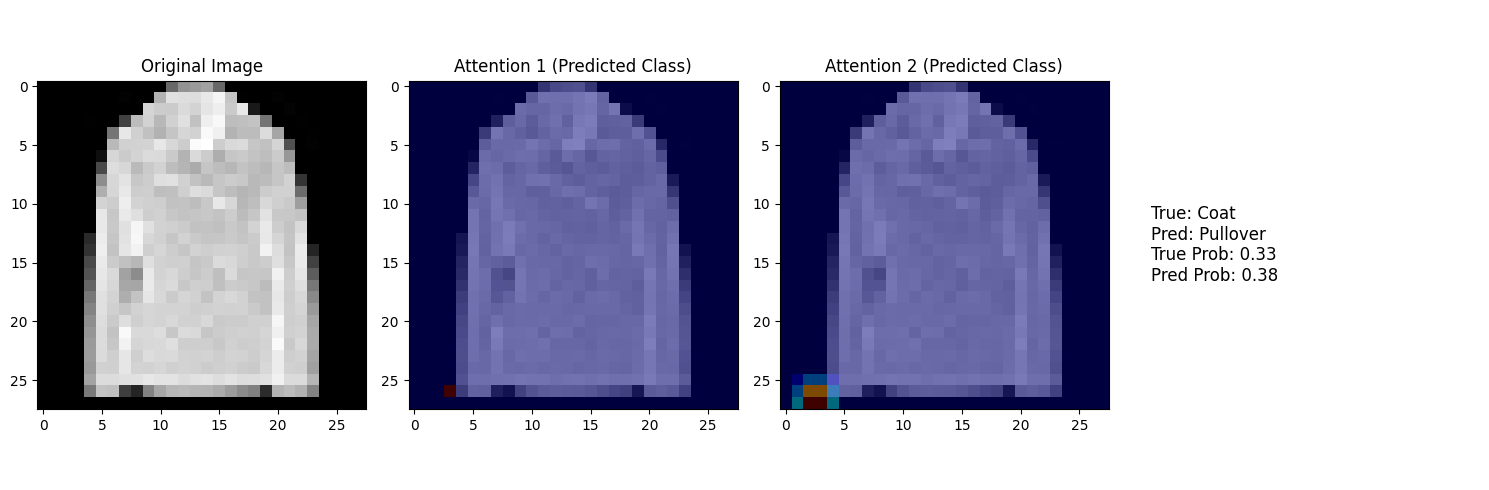

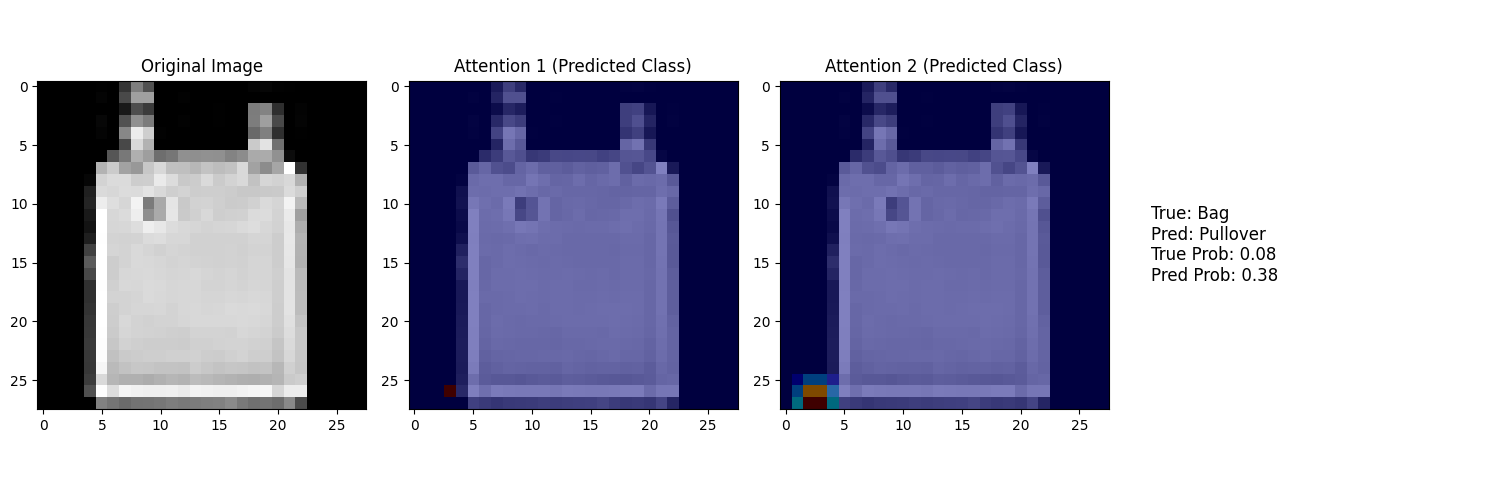

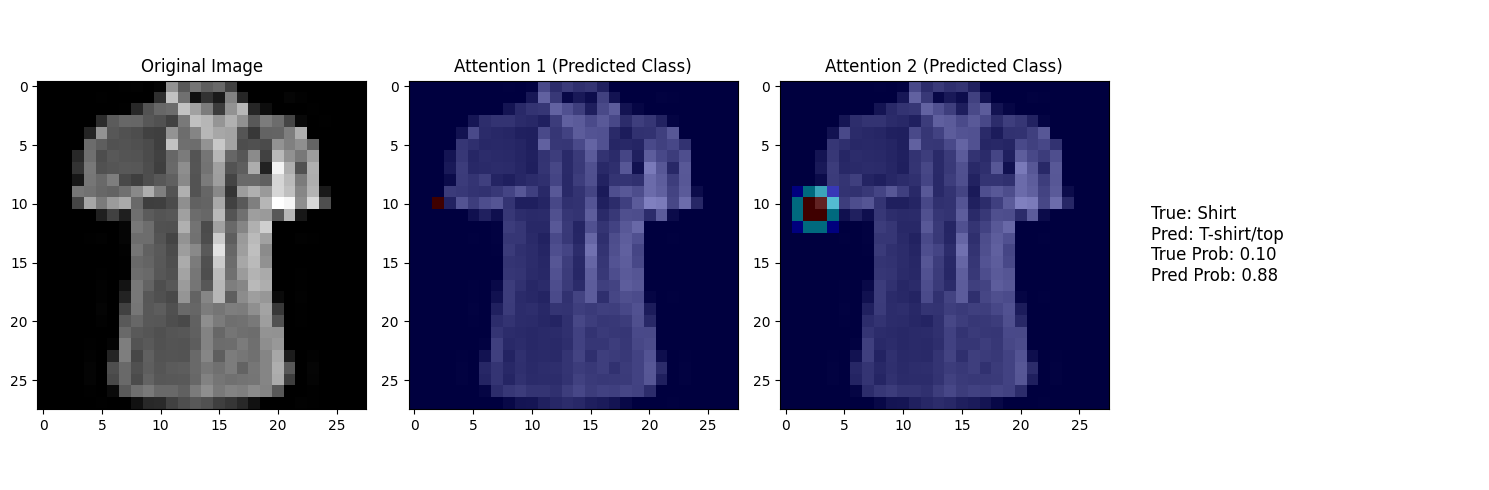

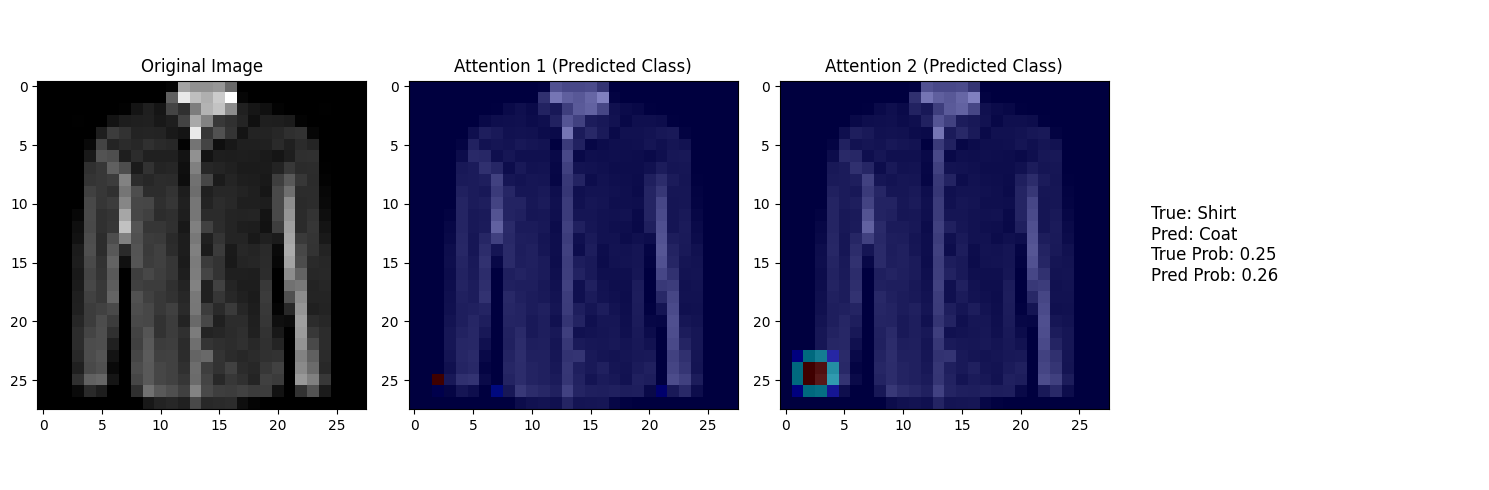

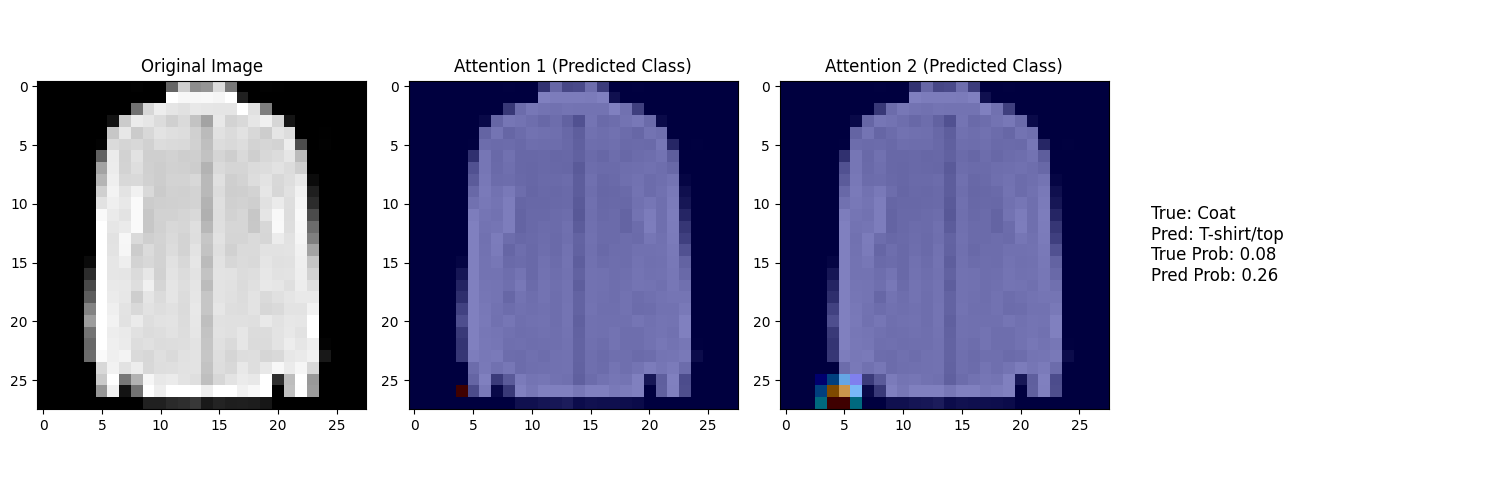

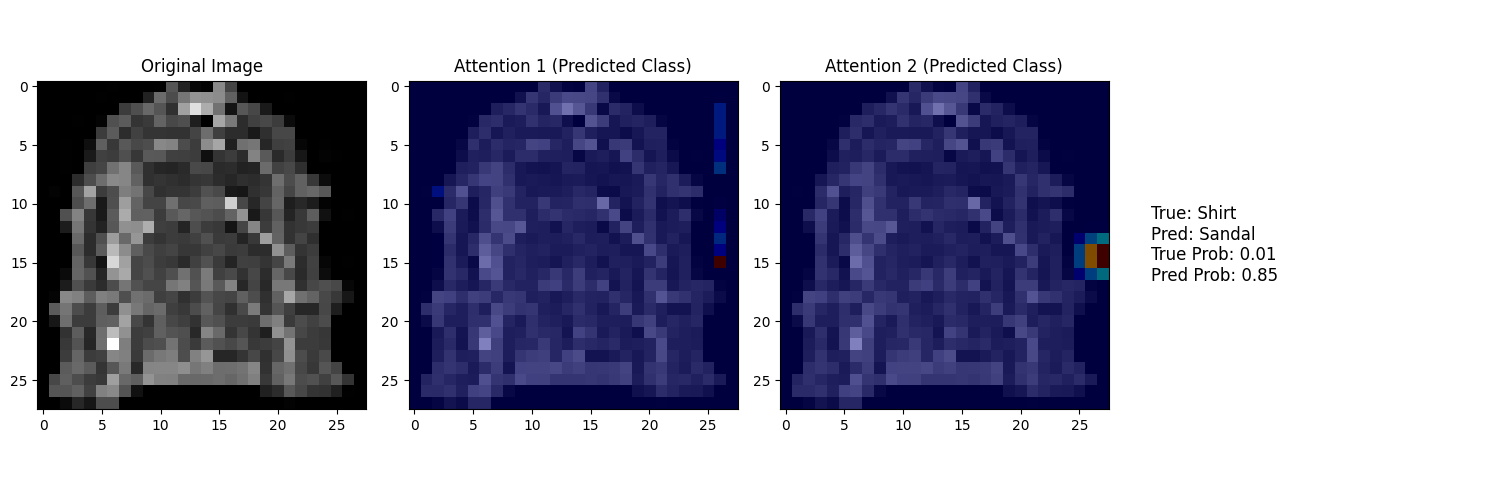

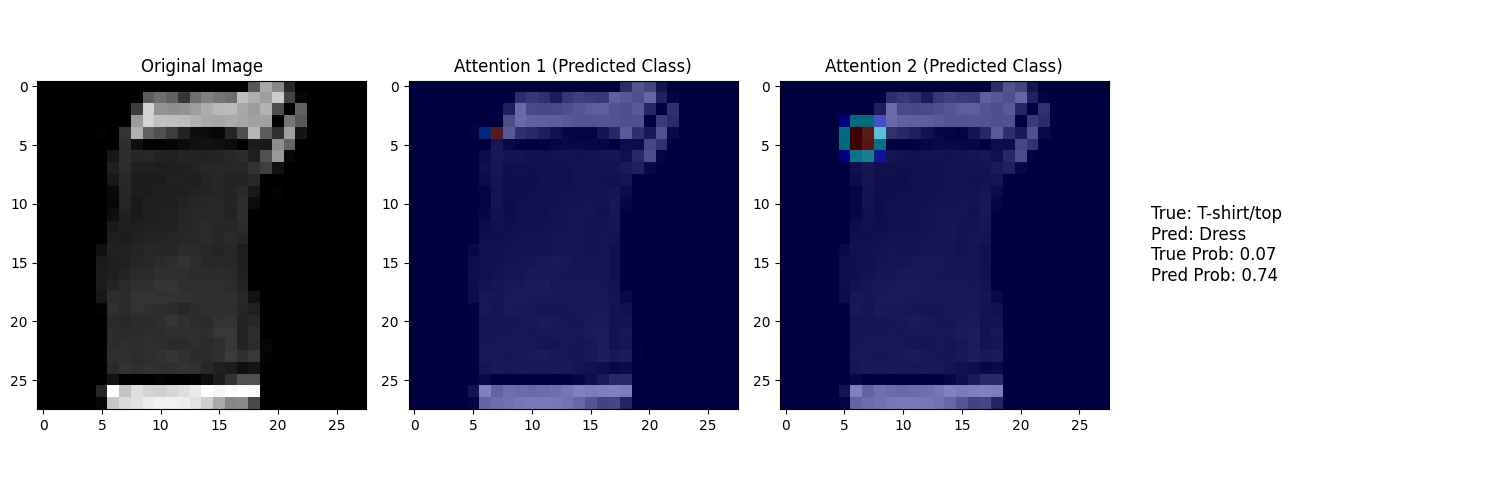

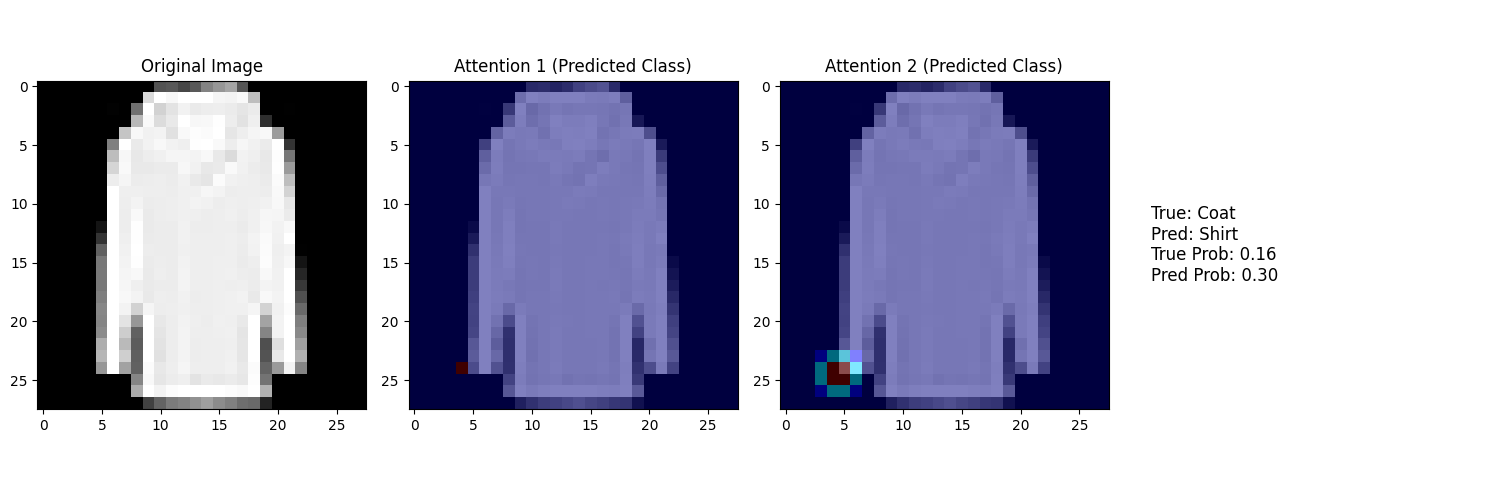

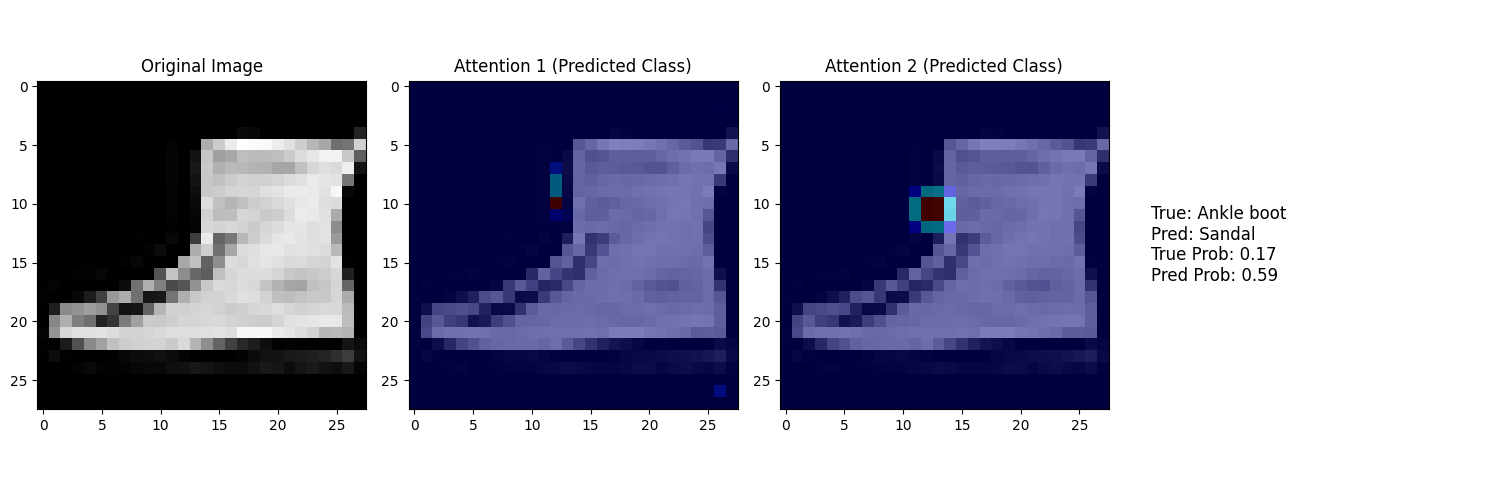

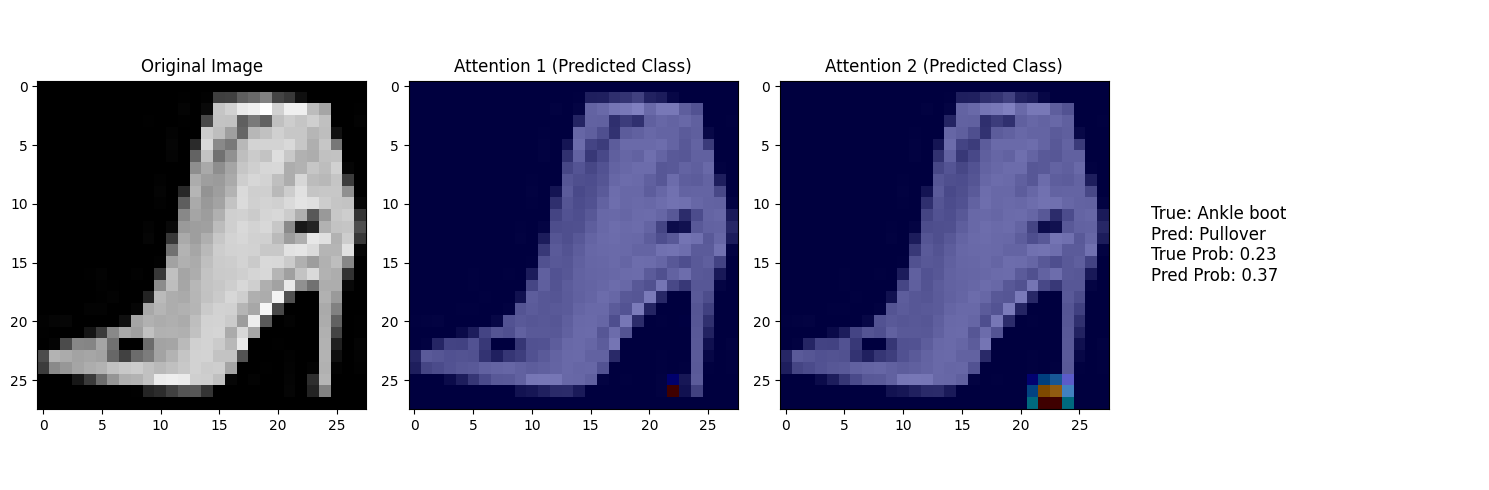

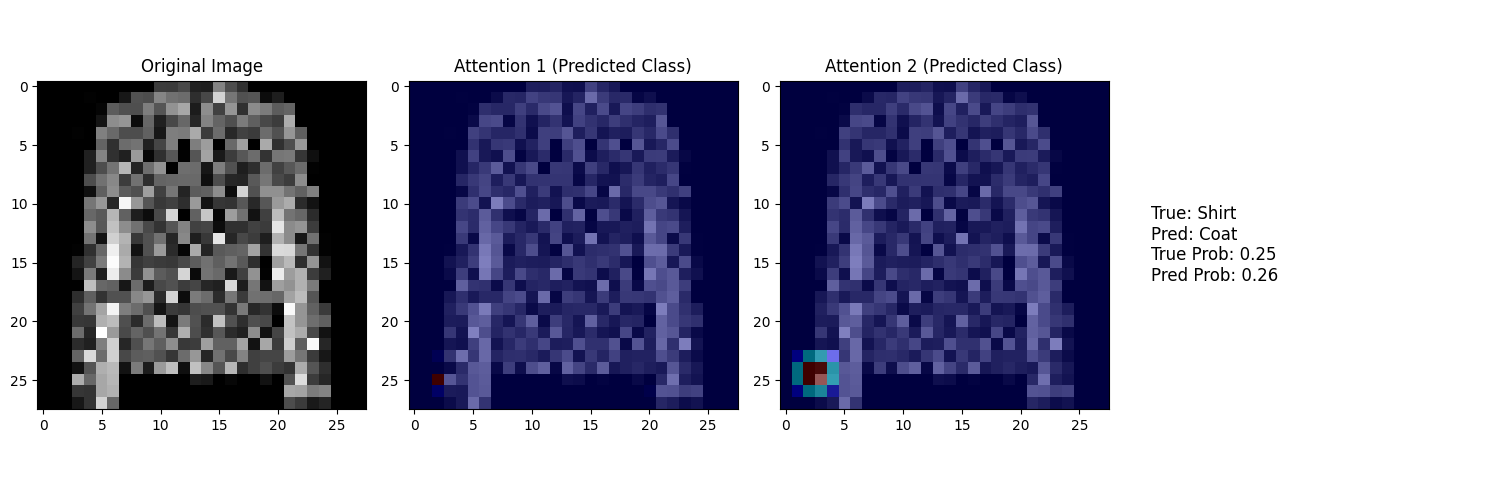

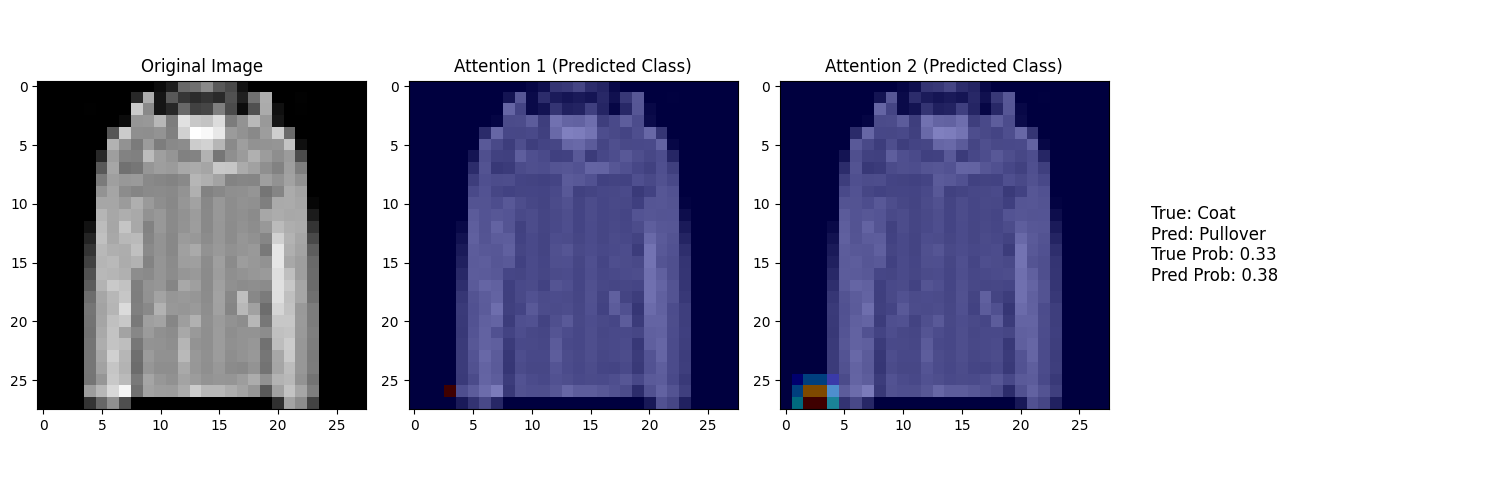

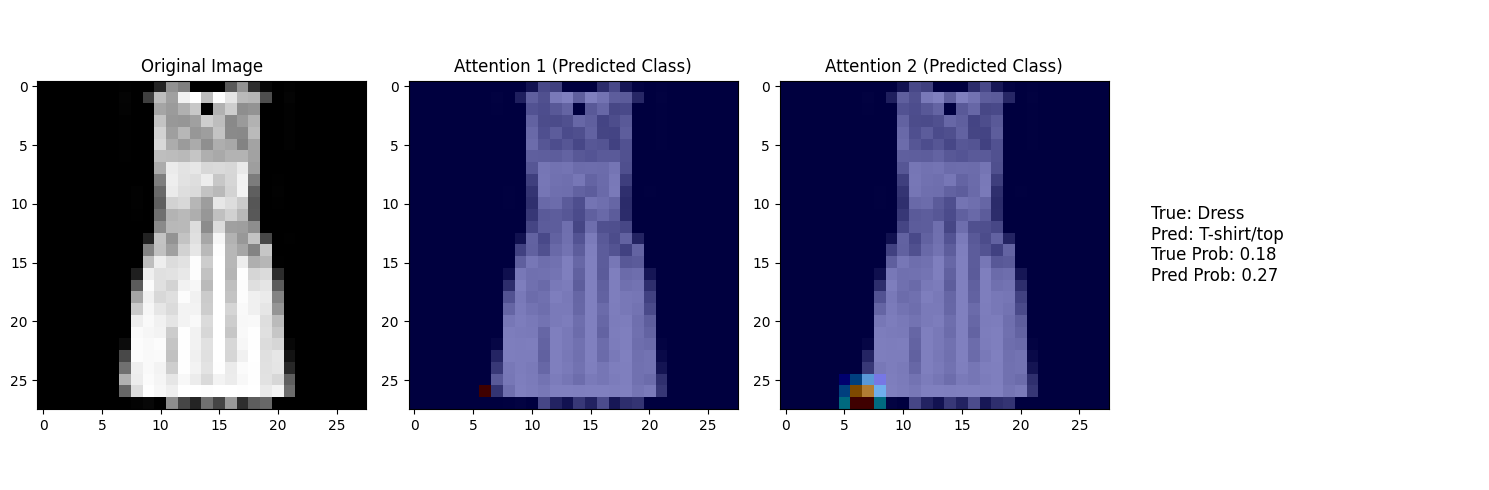

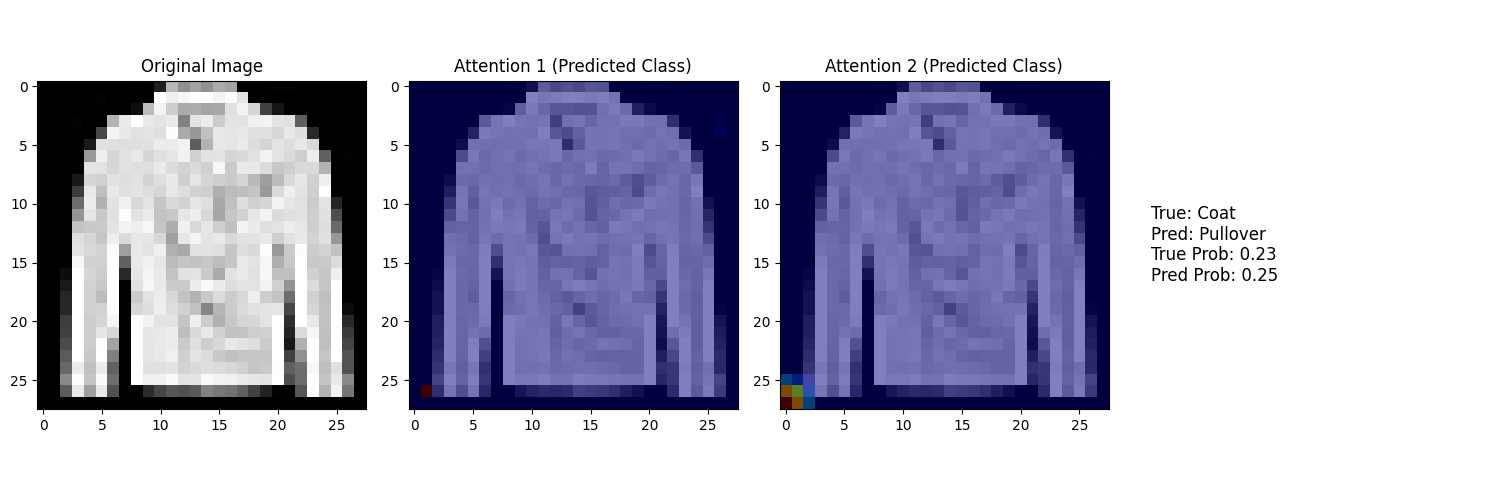

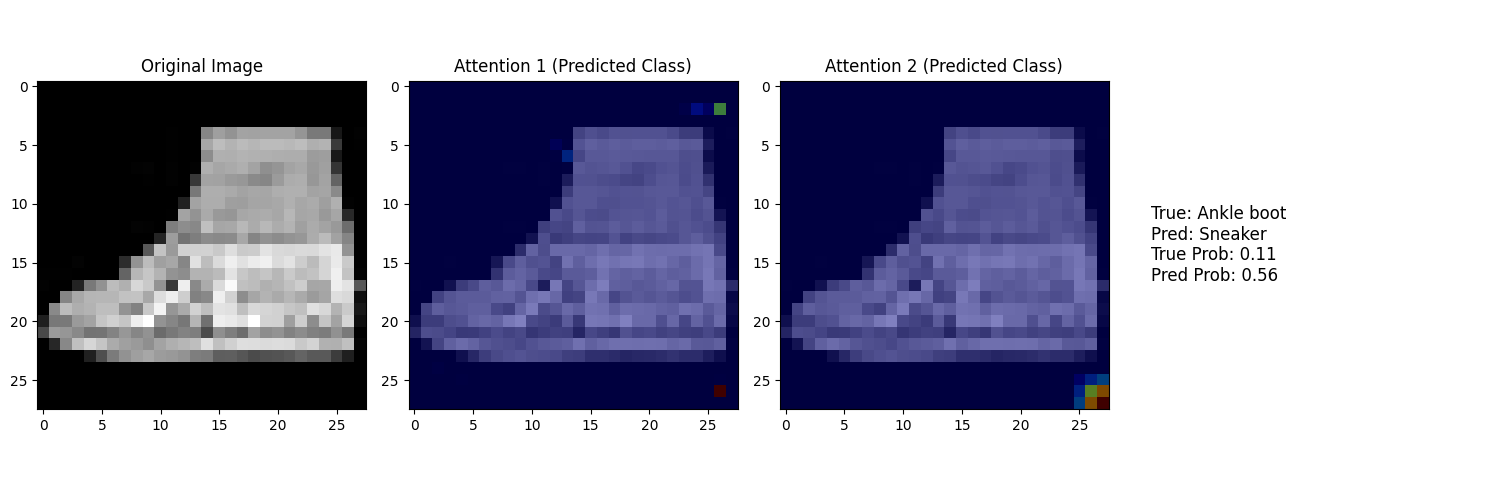

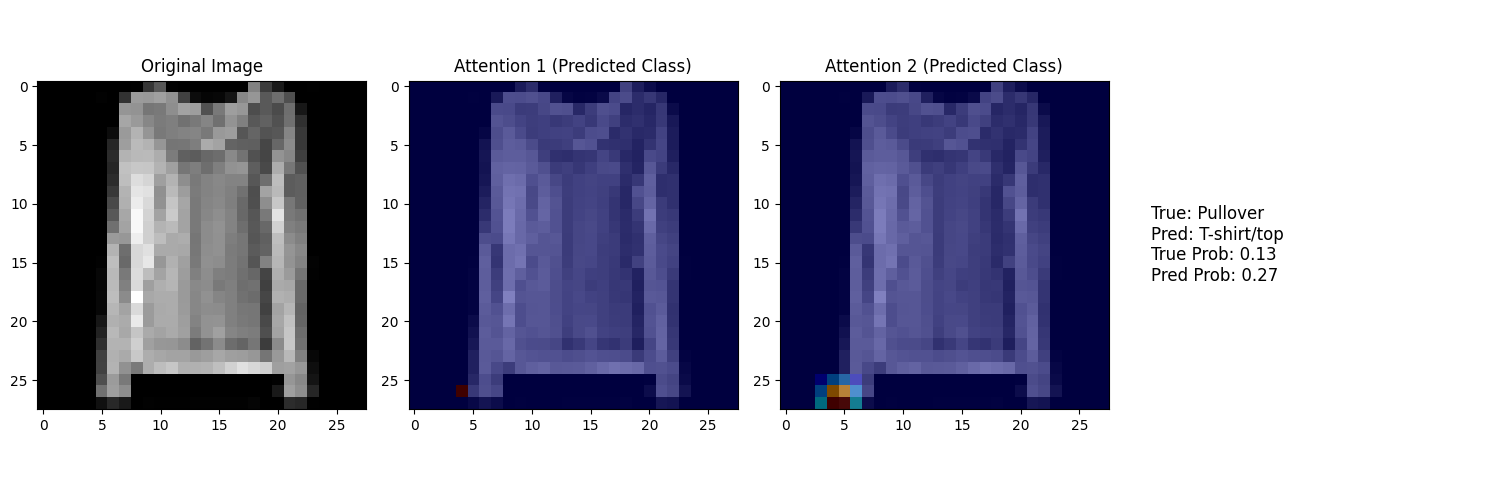

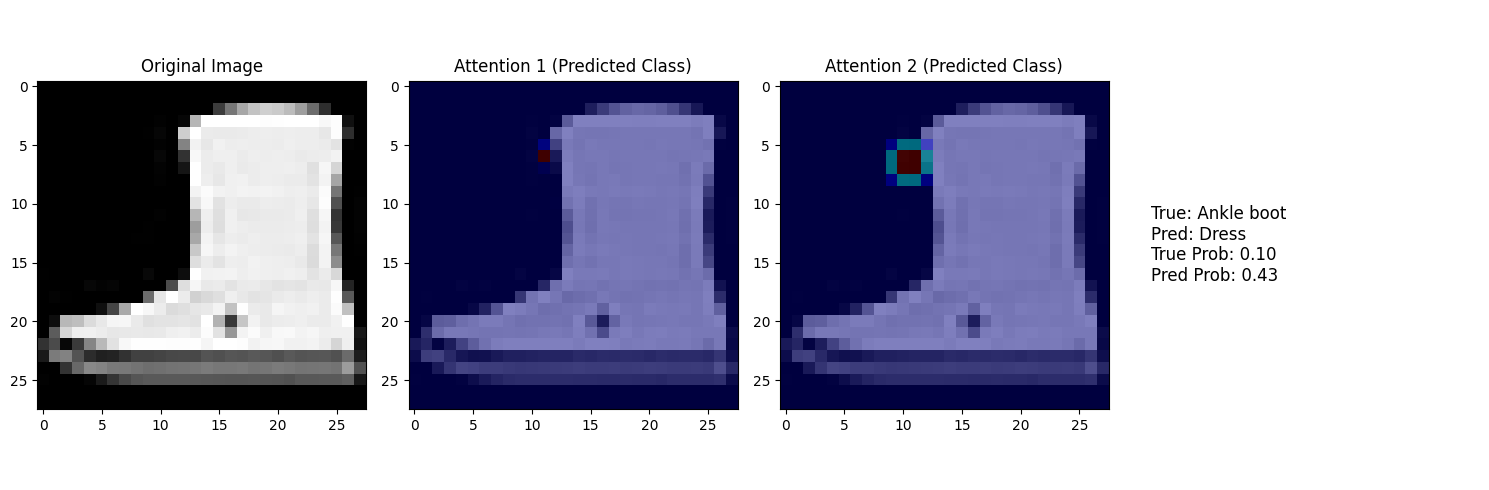

In [26]:
# Define class names for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get 30 incorrect samples
incorrect_samples = get_incorrect_samples(model, test_loader, num_samples=30, device=device)

# Visualize the incorrect predictions with attention maps
visualize_incorrect_predictions(incorrect_samples, class_names)
